In [ ]:
!git clone https://github.com/obss/sahi.git

Cloning into 'sahi'...
remote: Enumerating objects: 5128, done.
remote: Counting objects: 100% (417/417), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 5128 (delta 306), reused 180 (delta 166), pack-reused 4711 (from 3)
Receiving objects: 100% (5128/5128), 176.36 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (3192/3192), done.


In [ ]:
import os
os.getcwd()

'/content'

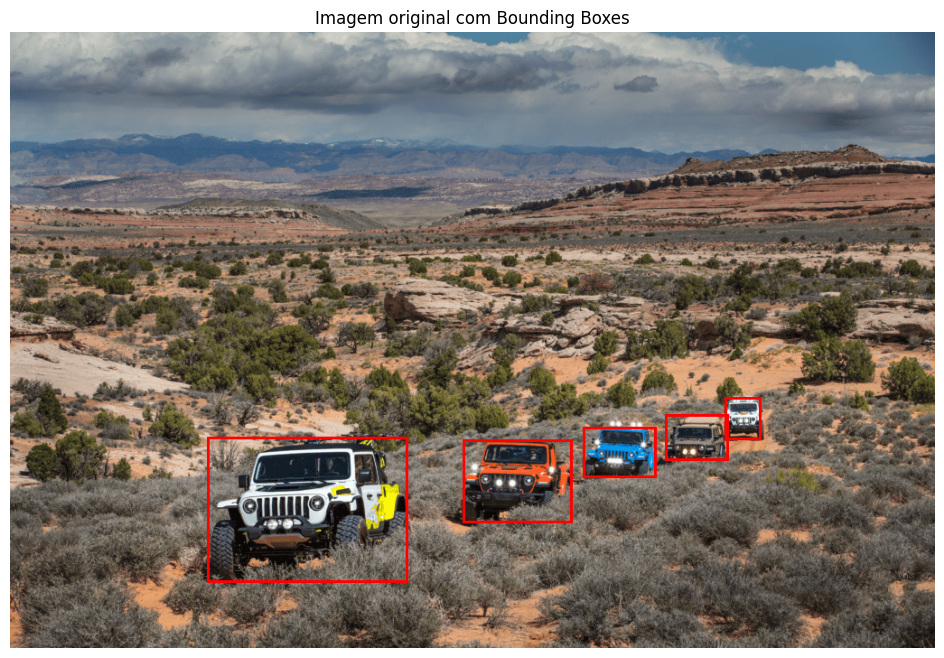

In [ ]:
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Caminhos
image_path = "/content/sahi/demo/demo_data/terrain2.png"
coco_json_path = "/content/sahi/demo/demo_data/terrain2_coco.json"

# Carregar annotations
with open(coco_json_path) as f:
    coco_dict = json.load(f)

# Abrir imagem
img = Image.open(image_path).convert("RGBA")
draw = ImageDraw.Draw(img, 'RGBA')

# Desenhar todos os bounding boxes
for ann in coco_dict["annotations"]:
    x, y, w, h = ann["bbox"]
    draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

# Plotar
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.title("Imagem original com Bounding Boxes")
plt.show()


2025-08-27 01:48:54,776 - sahi - INFO - image.shape: (1024, 682) (slicing.py:322)
INFO:sahi:image.shape: (1024, 682)
2025-08-27 01:48:54,781 - sahi - INFO - Num slices: 20 slice_height: 256 slice_width: 256 (slicing.py:396)
INFO:sahi:Num slices: 20 slice_height: 256 slice_width: 256


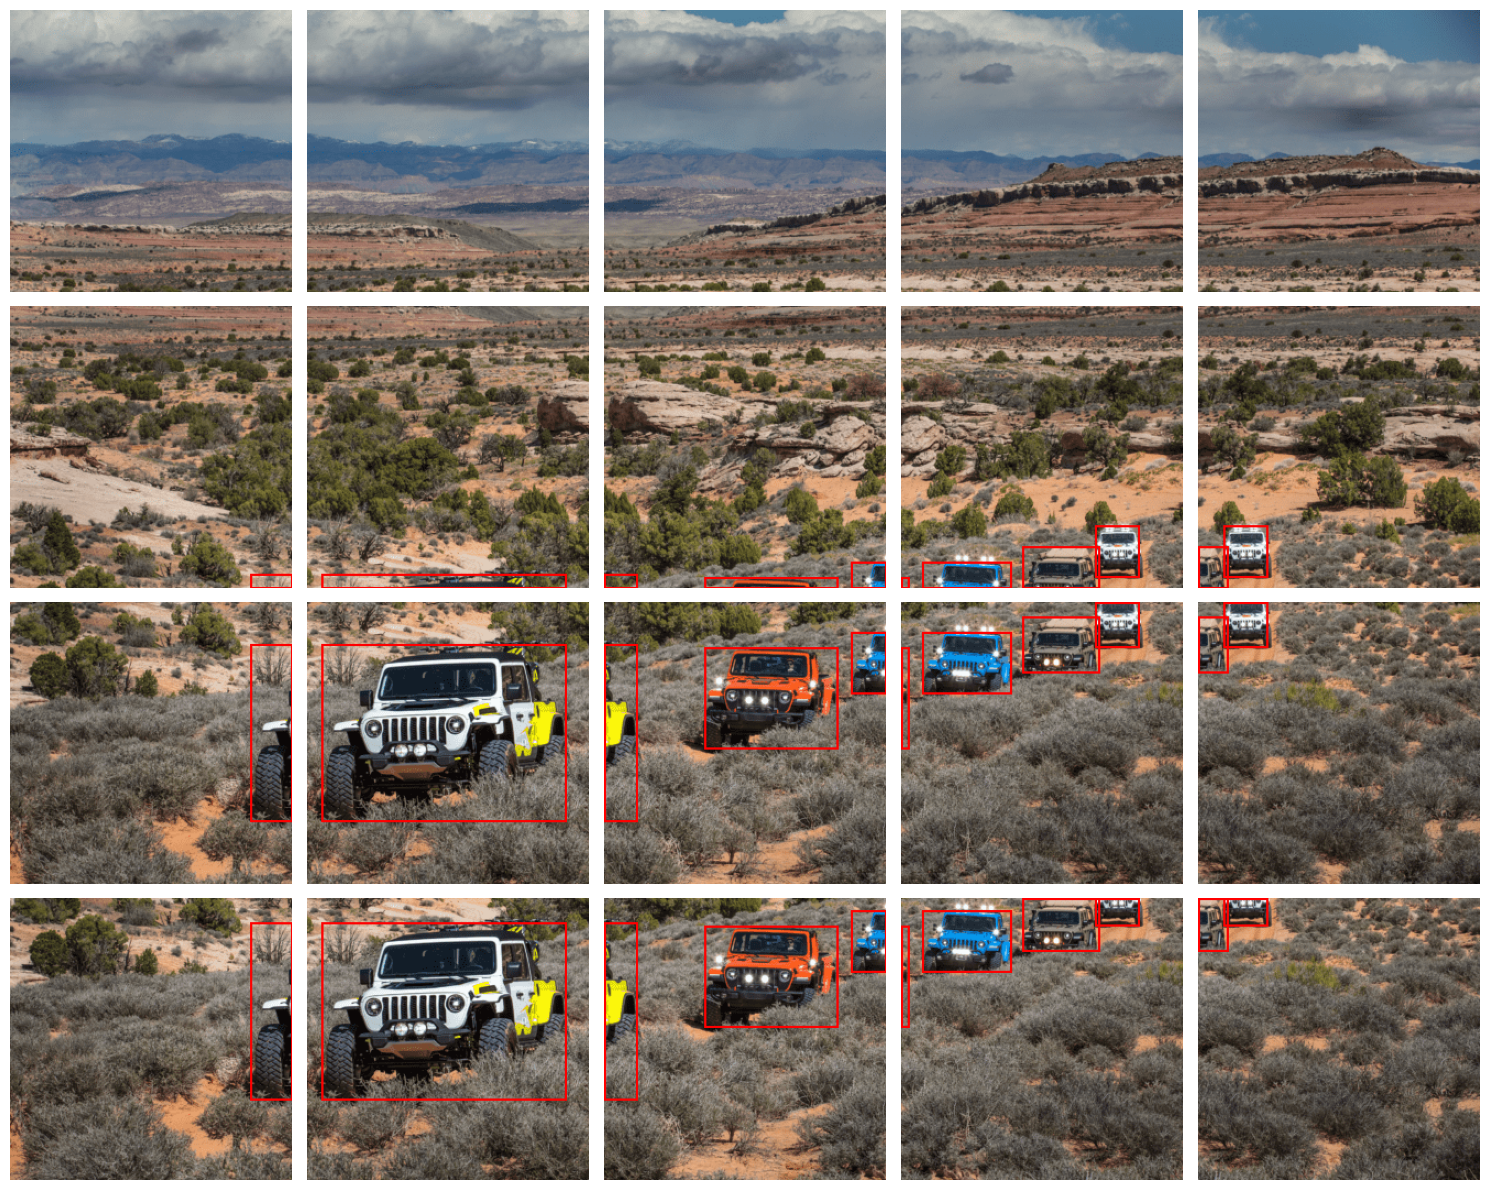

In [ ]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sahi.slicing import slice_image
import json

# ----------------------------
# Caminhos
# ----------------------------
image_path = "/content/sahi/demo/demo_data/terrain2.png"
output_dir = "/content/sahi/demo/demo_data/sliced/"
os.makedirs(output_dir, exist_ok=True)

# ----------------------------
# Parâmetros de slice
# ----------------------------
slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

# ----------------------------
# COCO original
# ----------------------------
with open("/content/sahi/demo/demo_data/terrain2_coco.json") as f:
    coco = json.loadf()

orig_img = Image.open(image_path)
orig_width, orig_height = orig_img.size

# ----------------------------
# Fatiar imagem
# ----------------------------
slices = slice_image(
    image=image_path,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
    verbose=True
)

# ----------------------------
# Preparar COCO das fatias
# ----------------------------
coco_sliced = {"images": [], "annotations": [], "categories": coco["categories"]}
slice_id = 0
ann_id = 0

# Passo do slice
step_x = slice_width - int(overlap_width_ratio * slice_width)
step_y = slice_height - int(overlap_height_ratio * slice_height)

# Número de slices
num_cols = (orig_width - 1) // step_x + 1
num_rows = (orig_height - 1) // step_y + 1

for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        if idx >= len(slices):
            continue

        s = slices[idx]
        slice_img = Image.fromarray(s["image"])
        slice_w, slice_h = slice_img.size  # tamanho real da fatia

        # Coordenadas da slice na imagem original (corrigido última linha/coluna)
        x0 = min(col * step_x, orig_width - slice_w)
        y0 = min(row * step_y, orig_height - slice_h)

        slice_filename = f"slice_{slice_id}.png"
        slice_img.save(os.path.join(output_dir, slice_filename))

        # Adicionar info da slice
        coco_sliced["images"].append({
            "id": slice_id,
            "file_name": slice_filename,
            "width": slice_w,
            "height": slice_h
        })

        # Ajustar bboxes originais
        for ann in coco["annotations"]:
            bx, by, bw, bh = ann["bbox"]
            # Interseção bbox x slice
            ix0 = max(bx, x0)
            iy0 = max(by, y0)
            ix1 = min(bx + bw, x0 + slice_w)
            iy1 = min(by + bh, y0 + slice_h)
            if ix1 > ix0 and iy1 > iy0:
                coco_sliced["annotations"].append({
                    "id": ann_id,
                    "image_id": slice_id,
                    "category_id": ann["category_id"],
                    "bbox": [ix0 - x0, iy0 - y0, ix1 - ix0, iy1 - iy0],
                    "iscrowd": ann.get("iscrowd", 0),
                    "area": (ix1 - ix0) * (iy1 - iy0)
                })
                ann_id += 1

        slice_id += 1

# ----------------------------
# Mostrar todas as fatias com bboxes
# ----------------------------
cols = 5
rows = (len(coco_sliced["images"]) + cols - 1) // cols
f, axarr = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for idx, img_info in enumerate(coco_sliced["images"]):
    img = Image.open(os.path.join(output_dir, img_info["file_name"])).convert("RGBA")
    draw = ImageDraw.Draw(img, 'RGBA')
    for ann in coco_sliced["annotations"]:
        if ann["image_id"] == img_info["id"]:
            x, y, w, h = ann["bbox"]
            draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
    r, c = idx // cols, idx % cols
    axarr[r, c].imshow(img)
    axarr[r, c].axis("off")

# Remover eixos extras
for extra in range(idx + 1, rows * cols):
    r, c = extra // cols, extra % cols
    axarr[r, c].axis("off")

plt.tight_layout()
plt.show()
